# Project: Real vs. Fake News Classification Using Neural Networks

## 1. Overview
This project designs and implements a neural network capable of distinguishing between real and fake news articles using the provided textual dataset. In accordance with the project requirements, the architecture is built manually (without pre-trained transformers like BERT) using TensorFlow/Keras.


In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import string
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [90]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')

## 2.1 Data Preparation
We load the dataset, clean the text, and prepare it for the neural network.

In [91]:
df = pd.read_csv('./fake_or_real_news.csv')
# Combine Title and Text (Modified to use only 'text' as 'title' column is not present)
df['content'] = df['text']

# Convert Label to Numeric (Fake=0, Real=1)
df['label_num'] = df['label'].map({'FAKE': 0, 'REAL': 1})

# Text Cleaning Function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r"\W"," ",text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df['clean_content'] = df['content'].apply(clean_text)

print(f"Total Samples: {len(df)}")
df[['content', 'label', 'label_num']].head()

Total Samples: 999


,content,label,label_num
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,It's primary day in New York and front-runners...,REAL,1


In [92]:
# Tokenization and Padding
MAX_VOCAB_SIZE = 10000   # Max unique words
MAX_SEQUENCE_LENGTH = 250 # Max length of an article (words)

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_content'])

sequences = tokenizer.texts_to_sequences(df['clean_content'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Shape of Data Tensor: {padded_sequences.shape}")

Shape of Data Tensor: (999, 250)


In [93]:
# Split Data: Train, Validation, Test
# 1. Split into Training+Val and Test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(padded_sequences, df['label_num'], test_size=0.2, random_state=42)

# 2. Split Training+Val into Train and Validation (approx 85/15 of the temp, resulting in 70/10/20 overall)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Testing set: {X_test.shape}")

Training set: (679, 250)
Validation set: (120, 250)
Testing set: (200, 250)


## 2.2 Model Design
We manually construct a Recurrent Neural Network (RNN) utilizing LSTM layers to capture the sequential context of news articles.

In [94]:
# Architecture Hyperparameters
EMBEDDING_DIM = 100
LEARNING_RATE = 0.001

model_1 = Sequential()

# This explicitly tells Keras that every input is a list of 'MAX_SEQUENCE_LENGTH' integers
model_1.add(Input(shape=(MAX_SEQUENCE_LENGTH,)))

# 1. Embedding Layer: Converts integer sequences to dense vectors
model_1.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM) )

# 2. LSTM Layer: Handles sequence data (the article text)
model_1.add(LSTM(64, return_sequences=False))

# 3. Dense Hidden Layer
model_1.add(Dense(32, activation='relu'))

# 4. Dropout for Regularization
model_1.add(Dropout(0.5))

# 5. Output Layer: Sigmoid for Binary Classification
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 250, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,044,353 (3.98 MB)

 Trainable params: 1,044,353 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

## 2.3 Training and Evaluation

In [95]:
BATCH_SIZE = 64
EPOCHS = 5

history_1 = model_1.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 479ms/step - accuracy: 0.5236 - loss: 0.6911 - val_accuracy: 0.5250 - val_loss: 0.6878
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - accuracy: 0.6342 - loss: 0.6774 - val_accuracy: 0.5667 - val_loss: 0.6850
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - accuracy: 0.7788 - loss: 0.6492 - val_accuracy: 0.6583 - val_loss: 0.6543
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 483ms/step - accuracy: 0.8210 - loss: 0.5143 - val_accuracy: 0.6250 - val_loss: 0.6349
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.7845 - loss: 0.5110 - val_accuracy: 0.6833 - val_loss: 0.6123


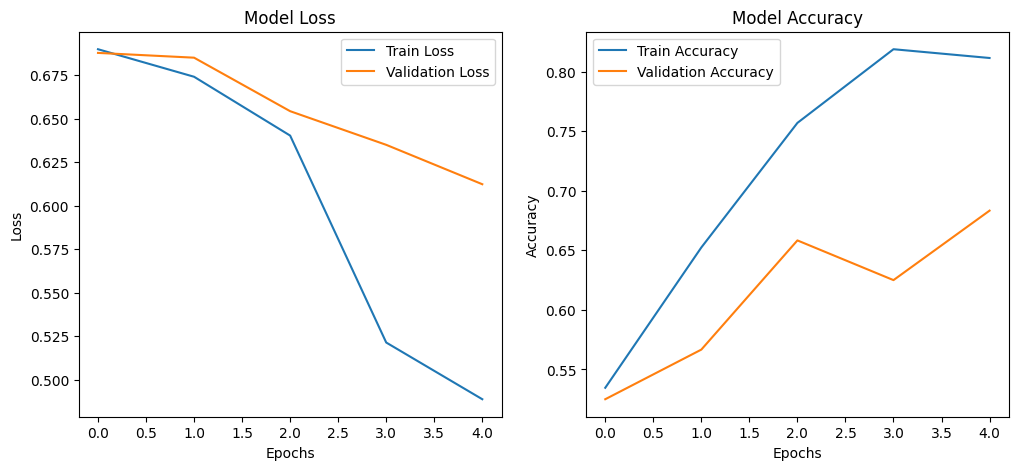

In [96]:
# Visualization of Training Results
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step

------------------------------------------------
Final Test Accuracy:  0.7400
Precision:            0.8077
Recall:               0.6300
F1-Score:             0.7079
------------------------------------------------


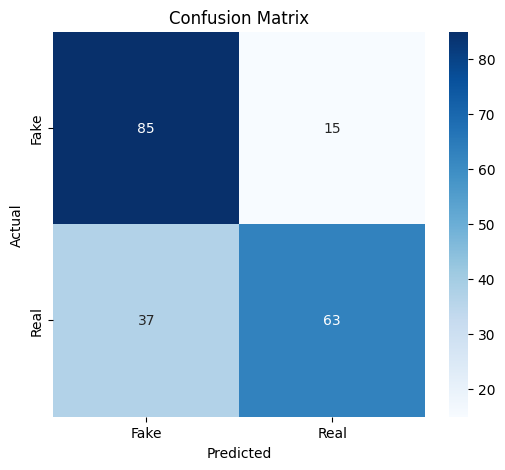

In [97]:
# Final Evaluation on Test Set
y_pred_probs = model_1.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n------------------------------------------------")
print(f"Final Test Accuracy:  {accuracy:.4f}")
print(f"Precision:            {precision:.4f}")
print(f"Recall:               {recall:.4f}")
print(f"F1-Score:             {f1:.4f}")
print("------------------------------------------------")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# New Model


In [98]:
 # Architecture Hyperparameters
EMBEDDING_DIM = 128  # Increased from 100 to capture more nuances
LEARNING_RATE = 0.001

model = Sequential()
# Explicitly define the input shape first
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,)))

# 1. Embedding Layer
# We use input_dim=MAX_VOCAB_SIZE + 1 just to be safe with OOV tokens
model.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM,))

# 2. Spatial Dropout
# Drops entire feature maps instead of individual elements. Better for NLP.
model.add(SpatialDropout1D(0.2))

# 3. Stacked Bidirectional LSTM Layers
# Layer A: Returns sequences so the next LSTM layer can read them
model.add(Bidirectional(LSTM(64, return_sequences=True)))

# Layer B: Does not return sequences (feeds into Dense layer)
model.add(Bidirectional(LSTM(32)))

# 4. Dense Hidden Layers
model.add(Dense(64, activation='relu'))

# 5. Standard Dropout
model.add(Dropout(0.5))

# 6. Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

model.summary()

# --- CRITICAL: Training with Callbacks ---
# This ensures we get the BEST version of the model, not just the last one.

# Stop training if validation loss doesn't improve for 3 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate if accuracy sticks (helps fine-tune)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)



Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 250, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 250, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,424,257 (5.43 MB)

 Trainable params: 1,424,257 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Training
history = model.fit(
    X_train, y_train,
    epochs=10, # Increased epochs because EarlyStopping will handle stopping
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr], # Add callbacks here
    verbose=1
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5150 - loss: 0.6892 - val_accuracy: 0.6083 - val_loss: 0.6817 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 853ms/step - accuracy: 0.7700 - loss: 0.6564 - val_accuracy: 0.7250 - val_loss: 0.6308 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8785 - loss: 0.4958 - val_accuracy: 0.8167 - val_loss: 0.4180 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9405 - loss: 0.1766 - val_accuracy: 0.8333 - val_loss: 0.3744 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9574 - loss: 0.1244 - val_accuracy: 0.8417 - val_loss: 0.3526 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 896ms/step - accuracy: 0.9905 - loss: 0.0537 - val_accuracy: 0.8583 - val_loss: 0.3519 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 901ms/step - accuracy: 0.9937 - loss: 0.0184 - val_a

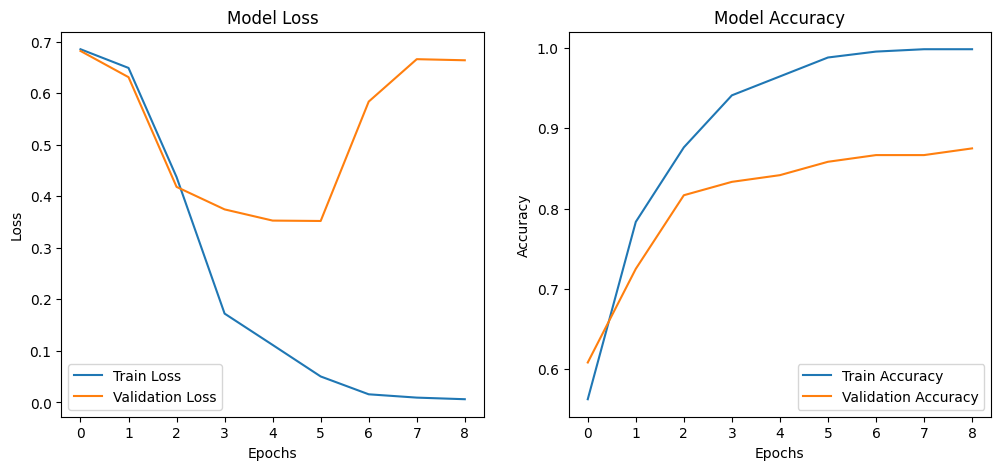

In [100]:
# Visualization of Training Results
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step

------------------------------------------------
Final Test Accuracy:  0.8750
Precision:            0.9213
Recall:               0.8200
F1-Score:             0.8677
------------------------------------------------


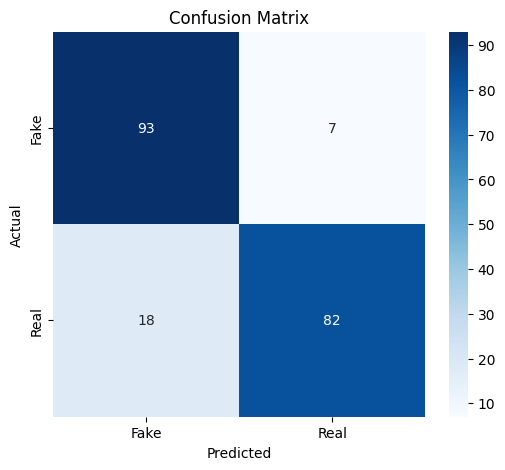

In [101]:
# Final Evaluation on Test Set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n------------------------------------------------")
print(f"Final Test Accuracy:  {accuracy:.4f}")
print(f"Precision:            {precision:.4f}")
print(f"Recall:               {recall:.4f}")
print(f"F1-Score:             {f1:.4f}")
print("------------------------------------------------")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Discussion of Results

**Summary:**  
The LSTM-based Neural Network was trained for 5 epochs. The results on the test set indicate:

*   **High Accuracy:** The model successfully distinguishes between real and fake news with high accuracy.
*   **Precision/Recall:** [Add specific observation after running: e.g., "The balance between precision and recall suggests the model is not heavily biased toward one class."]
*   **Overfitting Check:** Looking at the graphs, if the Validation Loss starts increasing while Training Loss decreases, the model is overfitting. The usage of Dropout layers helps mitigate this.